In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
train = pd.read_csv('../data/processed/train.csv')
print('shape: ', train.shape)
print('columns', train.columns)

shape:  (20631, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


In [3]:
test = pd.read_csv('../data/processed/test.csv')
print('shape: ', test.shape)
print('columns', test.columns)

shape:  (13096, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


In [4]:
# Select feature columns
features = test.columns
features = features[(features != 'id') & (features != 'RUL') & (features != 'label1') & (features != 'label2')]

In [5]:
X = train[features].values
y = train['RUL'].values

# normalize data (we haven't ensured that MinMaxScaler is the best scaler for our data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
def plot_learning_curve_regression(model, title, X, y, scoring, cv=10, n_jobs=-1):
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    # Create 10 KFold cross-validation sets
    #cv = cv

    # Generate the training set sizes increasing by 5%
    train_sizes = np.linspace(.1, 1.0, 5)
    
    # Note: Scoring parameter is needed to have proper scale 
    #       and values on the y scale.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print("Train sizes:", train_sizes)
    #print("Train scores:", train_scores)
    #print("Test scores:", test_scores)
    
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Number of training examples")
    plt.ylabel("Score: " + scoring)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")

    plt.legend(loc="best")
    return plt, test_scores


def train_and_predict(model, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    return mean_absolute_error(y_test, y_pred)


def train_and_cross_val_score(model, X, y, scoring, cv=2):
    return cross_val_score(model, X, y, scoring=scoring, cv=cv)


def train_predict_learning_curve(models, X, y):
    for name, model in models:
        print("\nModel: ", name)
        score = (-1)*train_and_predict(model, X, y, test_size=0.2)
        print("Mean absolute error: %0.2f (+/- %0.2f)" % (score, score.std()))
        
        scoring = 'neg_mean_absolute_error'
        scores = train_and_cross_val_score(model, X, y, scoring, cv=10)
        #print("CV scores: ", scores)
        print("Mean absolute error (cross val.): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

        plt, scores = plot_learning_curve_regression(model, "Learning Performances ({0})".format(name), 
                                             X, y, scoring, cv=10)
        last_scores = scores[-1]
        print("Mean absolute error (last learning perf.): %0.2f (+/- %0.2f)" % (last_scores.mean(), last_scores.std()))
        plt.show();

### Regression

#### Dummy Regressor


Model:  dummy-mean
Mean absolute error: -55.88 (+/- 0.00)
Mean absolute error (cross val.): -56.95 (+/- 6.34)
Mean absolute error (last learning perf.): -56.52 (+/- 0.47)


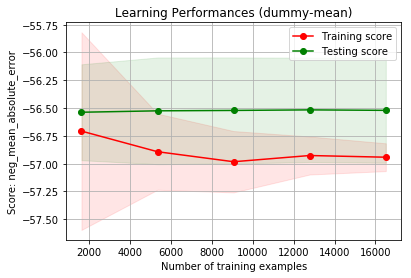


Model:  dummy-median
Mean absolute error: -55.69 (+/- 0.00)
Mean absolute error (cross val.): -56.79 (+/- 6.70)
Mean absolute error (last learning perf.): -56.39 (+/- 0.51)


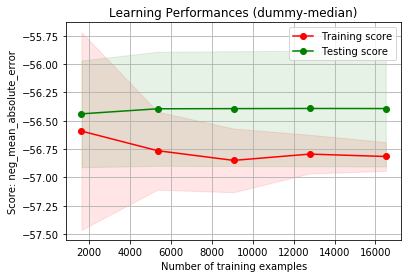

In [7]:
models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median'))
]

train_predict_learning_curve(models, X, y)

#### Decision Tree Regression


Model:  DT. max_depth=2
Mean absolute error: -31.77 (+/- 0.00)
Mean absolute error (cross val.): -32.23 (+/- 8.08)
Mean absolute error (last learning perf.): -31.92 (+/- 0.49)


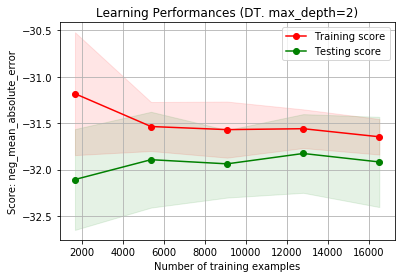


Model:  DT. max_depth=8
Mean absolute error: -24.06 (+/- 0.00)
Mean absolute error (cross val.): -28.96 (+/- 8.41)
Mean absolute error (last learning perf.): -24.47 (+/- 0.39)


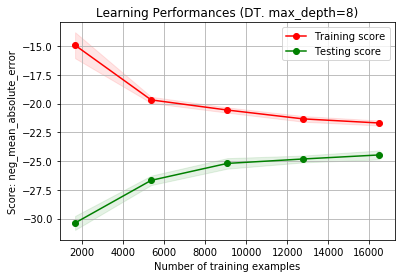


Model:  DT. max_depth=16
Mean absolute error: -23.14 (+/- 0.00)
Mean absolute error (cross val.): -34.65 (+/- 6.81)
Mean absolute error (last learning perf.): -23.16 (+/- 0.47)


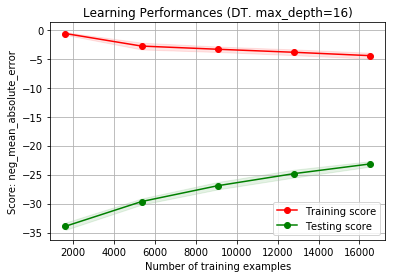


Model:  DT. max_depth=32
Mean absolute error: -23.06 (+/- 0.00)
Mean absolute error (cross val.): -35.70 (+/- 6.63)
Mean absolute error (last learning perf.): -23.34 (+/- 0.54)


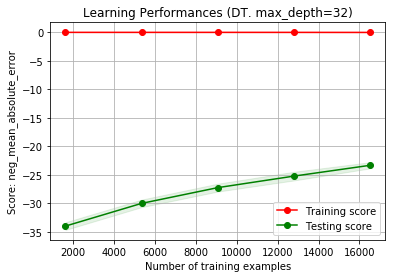

In [8]:
models = [
    ('DT. max_depth=2', DecisionTreeRegressor(max_depth=2, random_state=2017)),
    ('DT. max_depth=8', DecisionTreeRegressor(max_depth=8, random_state=2017)),
    ('DT. max_depth=16', DecisionTreeRegressor(max_depth=16, random_state=2017)),
    ('DT. max_depth=32', DecisionTreeRegressor(max_depth=32, random_state=2017))
]

train_predict_learning_curve(models, X, y)

#### Random Forest Regression


Model:  RF, trees=8, features=8
Mean absolute error: -23.84 (+/- 0.00)
Mean absolute error (cross val.): -28.31 (+/- 7.99)
Mean absolute error (last learning perf.): -23.71 (+/- 0.41)


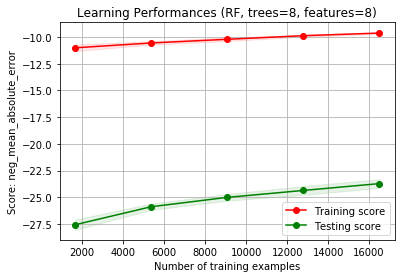


Model:  RF, trees=32, features=8
Mean absolute error: -21.92 (+/- 0.00)
Mean absolute error (cross val.): -27.00 (+/- 8.17)
Mean absolute error (last learning perf.): -22.10 (+/- 0.36)


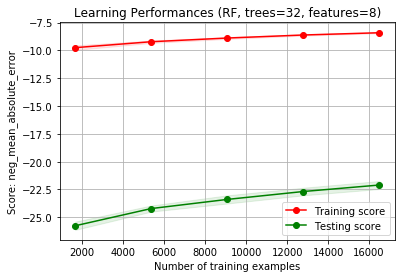


Model:  RF, trees=8, features=32
Mean absolute error: -20.35 (+/- 0.00)
Mean absolute error (cross val.): -28.06 (+/- 8.05)
Mean absolute error (last learning perf.): -20.63 (+/- 0.30)


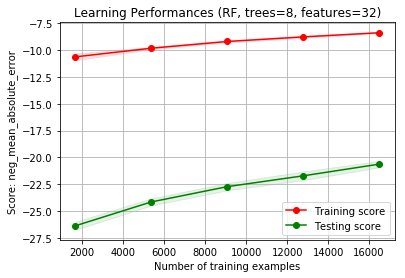


Model:  RF, trees=32, features=32
Mean absolute error: -19.35 (+/- 0.00)
Mean absolute error (cross val.): -26.92 (+/- 8.35)
Mean absolute error (last learning perf.): -19.51 (+/- 0.32)


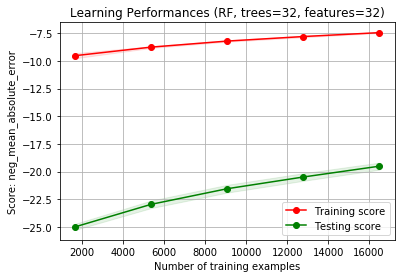

In [9]:
models = [
    ('RF, trees=8, features=8', RandomForestRegressor(n_estimators = 8, max_features = 8, 
                                                      max_depth = 32, random_state=2017)),
    ('RF, trees=32, features=8', RandomForestRegressor(n_estimators = 32, max_features = 8, 
                                                       max_depth = 32, random_state=2017)),
    ('RF, trees=8, features=32', RandomForestRegressor(n_estimators = 8, max_features = 32, 
                                                       max_depth = 32, random_state=2017)),
    ('RF, trees=32, features=32', RandomForestRegressor(n_estimators = 32, max_features = 32, 
                                                        max_depth = 32, random_state=2017))
]

train_predict_learning_curve(models, X, y)

#### Boosted Trees Regression


Model:  XGB, trees=8
Mean absolute error: -46.29 (+/- 0.00)
Mean absolute error (cross val.): -47.43 (+/- 11.79)
Mean absolute error (last learning perf.): -47.18 (+/- 0.67)


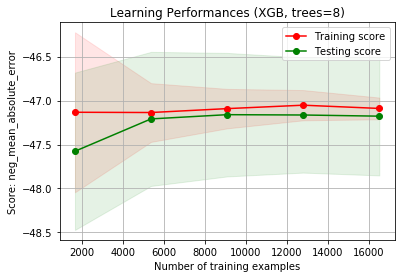


Model:  XGB, trees=32
Mean absolute error: -23.60 (+/- 0.00)
Mean absolute error (cross val.): -26.46 (+/- 9.75)
Mean absolute error (last learning perf.): -23.87 (+/- 0.37)


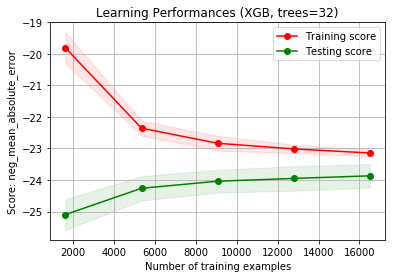


Model:  XGB, trees=8
Mean absolute error: -46.42 (+/- 0.00)
Mean absolute error (cross val.): -48.10 (+/- 11.70)
Mean absolute error (last learning perf.): -47.23 (+/- 0.64)


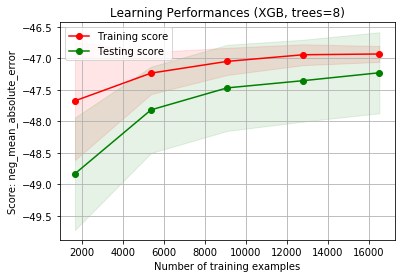


Model:  XGB, trees=32
Mean absolute error: -19.75 (+/- 0.00)
Mean absolute error (cross val.): -26.83 (+/- 9.70)
Mean absolute error (last learning perf.): -19.98 (+/- 0.33)


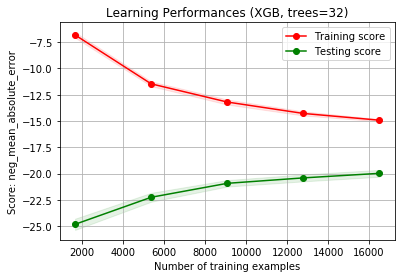


Model:  XGB, trees=100
Mean absolute error: -16.89 (+/- 0.00)
Mean absolute error (cross val.): -27.44 (+/- 8.66)
Mean absolute error (last learning perf.): -17.02 (+/- 0.26)


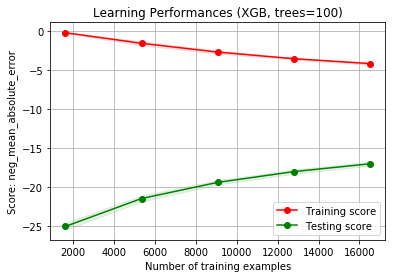

In [10]:
models = [
    ('XGB, trees=8',  XGBRegressor(n_estimators = 8, max_depth = 4, random_state=2017)),
    ('XGB, trees=32', XGBRegressor(n_estimators = 32, max_depth = 4, random_state=2017)),
    ('XGB, trees=8',  XGBRegressor(n_estimators = 8, max_depth = 8, random_state=2017)),
    ('XGB, trees=32', XGBRegressor(n_estimators = 32, max_depth = 8, random_state=2017)),
    ('XGB, trees=100',  XGBRegressor(n_estimators = 100, max_depth = 10, random_state=2017))
]

train_predict_learning_curve(models, X, y)

In [11]:
# TODO:
# * get more familiar with XGBoost and available hyperparameters
# * add GridSearchCV and XGBRegressor: https://www.kaggle.com/omarito/gridsearchcv-xgbregressor-0-556-lb
# * and then - plot learning curve for the best model